In [263]:
# import modules 
import cv2
import numpy as np
from glob import glob
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from math import sqrt
from scipy.spatial.transform import Rotation

from coppeliasim_zmqremoteapi_client import RemoteAPIClient

# escolha o conjunto de imagens
path = '../../../images/virtual/'
images = glob(path + '10x7/opengl3/*.jpg')

In [264]:
class Feed: 
    def __init__(self, title, res=(480,480), graphical=False):
        self.title = title
        self.graphical = graphical # Toggle to activate graphical mode
        self.res = res # Change feed dimensions 

        # Create Figure 
        self.figure = go.Figure(
            layout=go.Layout(
                height=700, 
                width=900, 
                title=go.layout.Title(text=self.title)
            )
        )

        self.figure.update_yaxes(
            scaleanchor="x",
            scaleratio=1
        )
        
        self.figure.update_layout(
            xaxis_title='x',
            yaxis_title='y',
            plot_bgcolor='white',
            font=dict(
                family='Arial',
                size=15,
                color='black'
            ),
            xaxis=dict(
                gridcolor='lightgray',
                dtick = res[0]/10,
                range=[0, self.res[0]]
            ),
            yaxis=dict(
                gridcolor='lightgray',
                dtick = res[1]/10,
                range=[self.res[1], 0]
            )
        )

        self.figure.add_shape(
            type='rect',
            x0=0, y0=0, x1=res[0], y1=res[1],
            line=dict(color='black'),
        )


    def add_points(self, point, name, color=None):
        self.figure.add_trace(
            go.Scatter(
                x=point[0],
                y=point[1],
                mode='markers',
                marker=dict(
                    size=5,
                    opacity=0.80,
                    color=color
                ),
                name=name,
                legendgroup='Points',
                legendgrouptitle_text='Points',
                showlegend=self.graphical
            )
        )

In [265]:
class Frame: 
    def __init__(self, R=np.eye(3), t=np.zeros((3, 1))):
        self.R = R
        self.t = t

In [266]:
class Viewer: 
    def __init__(self, title, graphical=False, size=5):
        self.title = title
        self.graphical = graphical # Toggle to activate graphical mode
        self.size = size # Change graph dimensions 

        # Create Figure 
        self.figure = go.Figure(
            layout=go.Layout(
                height=700, 
                width=900,
                title=go.layout.Title(text=self.title)
            )
        )

        # Set up layout enviroment
        self.figure.update_layout(
            scene_aspectmode='cube',
            scene = dict(
                xaxis_title='x'*self.graphical,
                yaxis_title='y'*self.graphical, 
                zaxis_title='z'*self.graphical, 
                xaxis=dict(
                    range=[-self.size,self.size],
                    showbackground=self.graphical,
                    showticklabels=self.graphical,
                    showaxeslabels=self.graphical,
                    showgrid=self.graphical,
                    showspikes=self.graphical
                    ),
                yaxis=dict(
                    range=[-self.size,self.size],
                    showbackground=self.graphical,
                    showticklabels=self.graphical,
                    showaxeslabels=self.graphical,
                    showgrid=self.graphical,
                    showspikes=self.graphical
                    ), 
                zaxis=dict(
                    range=[-self.size,self.size],
                    showbackground=self.graphical,
                    showticklabels=self.graphical,
                    showaxeslabels=self.graphical,
                    showgrid=self.graphical,
                    showspikes=self.graphical
                    )
            )
        )

        # Change camera settings
        self.figure.update_layout(
            scene=dict(
                camera=dict(
                    projection=dict(
                        type='orthographic'
                    )
                )
            )
        )

    def add_frame(self, frame, name, axis_size=1, color=None):

        # Set default colors
        axis_name_list = ['x', 'y', 'z']
        axis_color_list = ['red', 'green', 'blue']

        self.figure.add_trace(
            go.Scatter3d(
                x=frame.t[0],
                y=frame.t[1],
                z=frame.t[2],
                mode='markers',
                marker=dict(
                    size=4,
                    opacity=0.80,
                    color=color
                ),
                name=name,
                legendgroup='Frames',
                legendgrouptitle_text='Frames',
                showlegend=True
            )
        )

        for axis, axis_color in enumerate(axis_color_list):

            arrow = np.hstack((frame.t, frame.t + frame.R[:,axis].reshape(-1,1) * axis_size)) # Arrow of an axis

            self.figure.add_trace(
                go.Scatter3d(
                    x=arrow[0], 
                    y=arrow[1],
                    z=arrow[2], 
                    mode='lines',
                    line=dict(
                        width=2,
                        color=axis_color
                        ),
                    showlegend=False,
                    name=axis_name_list[axis]+name,
                    hoverinfo = None if self.graphical else 'skip'
                )
            )

    def add_points(self, point, name, color=None):
        self.figure.add_trace(
            go.Scatter3d(
                x=point[0],
                y=point[1],
                z=point[2],
                mode='markers',
                marker=dict(
                    size=3,
                    opacity=0.80,
                    color=color
                ),
                name=name,
                legendgroup='Points',
                legendgrouptitle_text='Points',
                showlegend=self.graphical
            )
        )

    def add_solid(self, vertices, name, color=None):
        self.figure.add_trace(
            go.Mesh3d(
                x=vertices[0],
                y=vertices[1],
                z=vertices[2],
                alphahull=0,
                color=color,
                flatshading=True,
                name=name,
                legendgroup='Objects',
                legendgrouptitle_text='Objects',
                showlegend=self.graphical
            )
        )
    def add_plane(self, vertices, name, color=None):
        self.figure.add_trace(
            go.Mesh3d(
                x=vertices[0],
                y=vertices[1],
                z=vertices[2],
                opacity=0.5,
                color=color,
                flatshading=True,
                name=name,
                legendgroup='References',
                legendgrouptitle_text='References',
                hoverinfo='skip',
                showlegend=True
            )
        )

    def connect_points_to_frame(self, points, frame, color):
        for p in range(points.shape[1]):
            edge = np.hstack((frame.t, points[:,[p]])) # Arrow of an axis
            self.figure.add_trace(
                go.Scatter3d(
                    x=edge[0], 
                    y=edge[1],
                    z=edge[2], 
                    mode='lines',
                    line=dict(
                        width=1,
                        color=color
                        ),
                    showlegend=False,
                    hoverinfo='skip'
                )
            )

    def camera_shape(self, points, frame, color):
        for p in range(points.shape[1]):
            edge = np.hstack((frame.t,points[:,[p]])) # Arrow of an axis
            self.figure.add_trace(
                go.Scatter3d(
                    x=edge[0], 
                    y=edge[1],
                    z=edge[2], 
                    mode='lines',
                    line=dict(
                        width=3,
                        color=color
                        ),
                    showlegend=False,
                    hoverinfo='skip'
                )
            )

        points = np.hstack([points, points[:,[0]]]) # Repeat first column in the last column

        self.figure.add_trace(
            go.Scatter3d(
                x=points[0],
                y=points[1],
                z=points[2],
                mode='lines',
                line=dict(
                    width=3,
                    color=color,
                    ),
                showlegend=False,
                hoverinfo='skip'
            )
        )

class Feed: 
    def __init__(self, title, res=(480,480), graphical=False):
        self.title = title
        self.graphical = graphical # Toggle to activate graphical mode
        self.res = res # Change feed dimensions 

        # Create Figure 
        self.figure = go.Figure(
            layout=go.Layout(
                height=700, 
                width=900, 
                title=go.layout.Title(text=self.title)
            )
        )

        self.figure.update_layout(
            xaxis_title='x',
            yaxis_title='y',
            plot_bgcolor='white',
            font=dict(
                family='Arial',
                size=15,
                color='black'
            ),
            xaxis=dict(
                gridcolor='lightgray',
                dtick = res[0]/10,
                range=[0, self.res[0]]
            ),
            yaxis=dict(
                gridcolor='lightgray',
                dtick = res[1]/10,
                range=[self.res[1], 0]
            )
        )

    def add_points(self, point, name, color=None):
        self.figure.add_trace(
            go.Scatter(
                x=point[0],
                y=point[1],
                mode='markers',
                marker=dict(
                    size=7,
                    opacity=0.80,
                    color=color
                ),
                name=name,
                legendgroup='Points',
                legendgrouptitle_text='Points',
                showlegend=self.graphical
            )
        )


In [267]:
# Random rotation matrix
def randR():
    return Rotation.from_euler('xyz', [np.random.randint(0, 360), np.random.randint(0, 360), np.random.randint(0, 360)], degrees=True).as_matrix()

# Random translation matrix
def randt(L): # Confined in a cube with an edge of length L
    return np.array([[2*L*np.random.random_sample()-L] for _ in range(3)])

# Rotate a point P in a observed frame O to be in respect to a main frame M 
def R(O, M):
    return np.array([[np.dot(O[0], M[0]), np.dot(O[1], M[0]), np.dot(O[2], M[0])],
                     [np.dot(O[0], M[1]), np.dot(O[1], M[1]), np.dot(O[2], M[1])],
                     [np.dot(O[0], M[2]), np.dot(O[1], M[2]), np.dot(O[2], M[2])]])

def RPY(R):
    return Rotation.from_rotvec(R).as_euler('xyz', degrees=True)

# Make coordinates homogeneous
def to_homo(points):
    return np.vstack((points, np.ones(points.shape[1]))) 

# Joins the rotation and translation matrices to make a homogeneous transformation
def join_homo(R, t):
    return np.vstack((np.hstack((R, t)), np.array([0, 0, 0, 1])))

# Extract the rotation and translation matrices from the homogeneous transformation
def split_homo(H):
    return H[0:3, 0:3], H[0:3 , [-1]]

# Returns the inverse of a homogeneous transformation matrix
def inverse_homo(H):
    R, t = split_homo(H)
    
    return join_homo(R.T, -R.T @ t)

# Returns the vertices of an unit cube with corner in origin
def cube(position=np.zeros(3).reshape(-1,1), size=1/2):
    vertices = np.array([[(V>>2)&1, (V>>1)&1, (V>>0)&1] for V in range(8)]).T*size+position

    return vertices

def rectangle(width = 1, height = 1):
    # Coordenadas dos vértices do retângulo
    x_coords = np.array([-width/2, width/2, width/2, -width/2])
    y_coords = np.array([height/2, height/2, -height/2, -height/2])

    # Criando um array com as coordenadas dos vértices
    rectangle_coords = np.row_stack((x_coords, y_coords,np.zeros(4)))
    
    return rectangle_coords

In [268]:
def build_intrinsic_matrix(fov_degrees, resolution):
    fov_radians = np.radians(fov_degrees)

    f_x = resolution[0]/(2*np.tan(fov_radians/2))
    f_y = resolution[1]/(2*np.tan(fov_radians/2))

    o_x = resolution[0]/2
    o_y = resolution[1]/2

    camera_matrix = np.array([[-f_x,   0, o_x, 0],
                              [  0, -f_y, o_y, 0],
                              [  0,    0,   1, 0]])

    return camera_matrix

def build_extrinsic_matrix(vision_sensor_handle, chessboard_handle = sim.handle_world):
    camera_pose = np.vstack((np.array(sim.getObjectMatrix(vision_sensor_handle, chessboard_handle)).reshape((3,4)), np.array([0, 0, 0, 1])))

    return camera_pose

def build_projection_matrix(intrinsic_matrix, extrinsic_matrix):
    projection_matrix = intrinsic_matrix @ inverse_homo(extrinsic_matrix) 

    return projection_matrix

def perspective_projection(points, projection_matrix):
    projected_point = projection_matrix @ points  # Project points to plane
    projected_point /= projected_point[-1]        # Normalize homogeneous coordinates
    projected_point = projected_point[:-1, :]     # Discard the last row
    #projected_point = projected_point.astype(int) # Cast as interger
    
    return projected_point

In [269]:
def construct3DPoints(patternSize,squareSize):
    X = np.zeros((patternSize[0]*patternSize[1],3), np.float32)
    X[:,:2] = np.mgrid[0:patternSize[0],0:patternSize[1]].T.reshape(-1,2)
    X = X * squareSize # Square size não interfere na calibração -> somente um fator de escala
                       # o square size não é utilizado na calibração dos cara de stanford
    return X

In [270]:
def detectCorners(images, boardPoints, patternSize):
    worldPoints = []
    imagePoints = [] 

    img_size = 0
    counter = 0
    for fname in images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img_size = gray.shape[::-1]
        ret, corners = cv2.findChessboardCornersSB(gray, patternSize, None)
        if ret == True:
            #print("Corners found in image " + str(fname)) #- see if corners are found 
            #corners2 = cv2.cornerSubPix(gray, corners, (11,11), (-1,-1), criteria=(cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001))
            worldPoints.append(boardPoints)
            imagePoints.append(corners)
            counter+=1

    print("Corners found in " + str(counter) + " images")
    #print(img_size)
    return worldPoints, imagePoints, img_size

In [271]:
def calibrate(worldPoints, imagePoints, imgSize, useFisheye, details = True):

    # boardPoints = construct3DPoints(patternSize, squareSize)

    # worldPoints, imagePoints, imgSize = detectCorners(images, boardPoints, patternSize)

    if useFisheye:
        flagsCalib = cv2.fisheye.CALIB_RECOMPUTE_EXTRINSIC+cv2.fisheye.CALIB_FIX_SKEW+cv2.fisheye.CALIB_CHECK_COND
        calibrateCriteria = (cv2.TERM_CRITERIA_EPS+cv2.TERM_CRITERIA_MAX_ITER,30, 1e-12)

        ret, cameraMatrix, k, R, t = cv2.fisheye.calibrate(np.expand_dims(np.asarray(worldPoints), -2), imagePoints, imgSize, None, None,
                                                                    flags=flagsCalib,criteria=calibrateCriteria)
    else:
        flagsCalib = cv2.CALIB_RATIONAL_MODEL

        ret, cameraMatrix, k, rvecs, tvecs, stdIntrinc, stdExtrinsic, perViewError = cv2.calibrateCameraExtended(worldPoints, imagePoints, imgSize, None, None,
                                                                flags=flagsCalib)
    if details:
        print("RMS re-projection error:", ret)
        print("The median re-projection error", np.median(perViewError))
        print("Camera Matrix:\n", cameraMatrix)
        print("Distortion Parameters:\n", k)

    return cameraMatrix, k, rvecs, tvecs, stdIntrinc, stdExtrinsic, perViewError


In [272]:
def calculate_mean_error(image_set, pattern_size, square_size, camera_matrix, distortion, per_view_error = False):
    
    # Create empty arrays for rotation and translation vectors
    rvecs = []
    tvecs = []
    errors = []
    
    # Define the world board points
    board_points = construct3DPoints(pattern_size, square_size)
    board_points = board_points.astype('float32')
    
    # Calculate image points in each image
    for image in image_set:
        img = cv2.imread(image)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        # Detect chessboard corners in the image
        ret, detected_image_points = cv2.findChessboardCornersSB(gray, pattern_size, None)
        
        # If it was detected
        if ret == True: 

            # Calculate extrinsic parameters 
            _, rvec, tvec = cv2.solvePnP(board_points, detected_image_points, camera_matrix, distortion)
            rvecs.append(rvec)
            tvecs.append(tvecs)

            # Calculate projected image points
            projected_image_points, _ = cv2.projectPoints(board_points, rvec, tvec, camera_matrix, distortion)

            # Find the Euclidean Distance between projected and detected image points
            error = cv2.norm(detected_image_points, projected_image_points, normType= cv2.NORM_L2) / len(projected_image_points)
            
            errors.append(error)
            
            if per_view_error:
                print(f"Mean Error of Image {image}:", error, "px")
    
    mean_error = np.median(errors)
    
    print("Median error: ", mean_error)
    
    return mean_error


In [273]:
def calculate_rms_error(pattern_size,square_size, images_points, camera_matrix, distortion, per_view_error = False):
    
    # Create empty arrays for rotation and translation vectors
    rvecs = []
    tvecs = []
    errors = []
    
    world_point = construct3DPoints(pattern_size, square_size)
    
    for idx, corners in enumerate(images_points):
        
        # Calculate extrinsic parameters
        _, rvec, tvec = cv2.solvePnP(world_point, corners, camera_matrix, distortion)
        rvecs.append(rvec)
        tvecs.append(tvecs)

        # Calculate projected image points
        projected_points, _ = cv2.projectPoints(world_point, rvec, tvec, camera_matrix, distortion)
    
        # Find the Euclidean Distance between projected and detected image points
        error = cv2.norm(corners, projected_points, normType= cv2.NORM_L2) / sqrt(len(corners))
        errors.append(error)
        if per_view_error:
            print(f"RMS Error of Image {idx}:", error, "px")

    rms_error = np.median(errors)

    print("Median RMS error: ", rms_error)

    return rms_error

In [274]:
def extract_camera_parameters(camera_matrix, distortion):
    
    fx,fy = camera_matrix[0][0], camera_matrix[1][1]
    cx,cy = camera_matrix[0][2], camera_matrix[1][2]

    camera_parameters = [fx,fy,cx,cy]

    for i in range(8):
        camera_parameters.append(distortion[0][i])

    return camera_parameters

In [275]:
def cross_validation_camera (world_points, images_points, K = 10):
    
    imgSize = (720,720)
    patternSize = (7,7)
    squareSize = 0.1
    flagsCalib = cv2.CALIB_RATIONAL_MODEL

    errors_train = []
    errors_test = []   

    for i in range (K):
    
        images_train, images_test, world_train, world_test = train_test_split(images_points, world_points, test_size=0.3)
        
        _, k_camera_matrix, k_distortion, _, _, _, _, _ = cv2.calibrateCameraExtended(world_train, images_train, imgSize, None, None,
                                                                flags=flagsCalib)
        
        error_train = calculate_rms_error(patternSize, squareSize, images_train, k_camera_matrix, k_distortion , per_view_error=False)
        errors_train.append(error_train)

        error_test = calculate_rms_error(patternSize, squareSize, images_test, k_camera_matrix, k_distortion , per_view_error=False)
        errors_test.append(error_test)

        print('\n')

    # Calcular Sigma E e Delta E

    print("Var E_train: ", np.var(errors_train, ddof=1))
    print("Var E_test: ", np.var(errors_test,ddof=1))

    print("Delta^2 E_KF: ", sqrt((np.var(errors_train, ddof=1) + np.var(errors_test, ddof=1))))
    
    return  

In [276]:
# Dados do Coppelia
# Declare intrinsic parameters
fov_degrees = 60.0
resolution = (720,720)

# Generate intrinsic parameters matrix
intrinsic_matrix = build_intrinsic_matrix(fov_degrees, resolution) 
print(intrinsic_matrix)

[[-623.53829072    0.          360.            0.        ]
 [   0.         -623.53829072  360.            0.        ]
 [   0.            0.            1.            0.        ]]


In [277]:
# Coppelia Remote Client
client = RemoteAPIClient()
sim = client.getObject('sim')

# Get the vision sensor handle
vision_sensor_handle = sim.getObject('/Vision_sensor') 
chessboard_handle = sim.getObject('/Cuboid[3]/Dummy')
cubo = sim.getObject('/Cuboid[3]')

In [278]:
import time

images_points = []
world_points = []

def sum_coord(A, B):
    for coord in range(len(A)):
        B[coord] += A[coord]
        
    return B 

patternSize = (7,7)

# Start simulation in CoppeliaSim
sim.startSimulation()

# Number of calibration images
number_of_images = 40

# See the Vision sensor image

for i in range(number_of_images):
    
    p=sim.getObjectPosition(cubo,-1)

    ds = randt(0.2)
    coord = sum_coord(p, ds).tolist()
    coord = [coord[0][0], coord[1][0], coord[2][0]]
    
    sim.setObjectPosition(cubo,-1, coord)
    
    extrinsic_matrix = build_extrinsic_matrix(vision_sensor_handle, chessboard_handle)
    
    projection_matrix = build_projection_matrix(intrinsic_matrix, extrinsic_matrix)

    board_points = construct3DPoints(patternSize = (7,7), squareSize = 0.1)

    world_points.append(board_points)
    
    points_to_project = to_homo(board_points.T) 

    projected_points = perspective_projection(points_to_project, projection_matrix)
    
    projected_points = projected_points.T

    images_points.append(projected_points)
    
    time.sleep(0.75)

sim.stopSimulation()

In [279]:
len(images_points)

40

In [280]:
corrected_image_points_vector = []
corrected_world_points_vector = []
for image in images_points:
    image = image.astype(np.float32)
    corrected_image_points_vector.append(image.reshape(49,1,2))

for world in world_points:
    world = world.astype(np.float32)
    corrected_world_points_vector.append(world.reshape(49,1,3))

In [316]:
ruido = np.random.normal(0,0.1, corrected_image_points_vector[0].shape)

noise_points = []

for image in corrected_image_points_vector:
    noise = ruido + image
    noise = noise.astype(np.float32)
    noise_points.append(noise)


In [317]:
total_image_points = np.stack(images_points, axis=0)
total_world_points = np.stack(world_points, axis=0)

In [318]:
imgSize = (720,720)
flagsCalib = cv2.CALIB_RATIONAL_MODEL

corrected_image_points_vector = noise_points

ret, cameraMatrix, k, rvecs, tvecs, stdIntrinc, stdExtrinsic, perViewError = cv2.calibrateCameraExtended(corrected_world_points_vector, corrected_image_points_vector, imgSize, None, None,
                                                                flags=flagsCalib)
print("RMS re-projection error:", ret)
print("Camera Matrix:\n", cameraMatrix)
print("Distortion Parameters:\n", k)
print("Per View Standart Deviation:", perViewError.std())

RMS re-projection error: 0.14444804922991003
Camera Matrix:
 [[549.67244616   0.         359.72325301]
 [  0.         553.55385856 385.73737897]
 [  0.           0.           1.        ]]
Distortion Parameters:
 [[-0.03253233 -0.03244478  0.00052414 -0.00082108 -0.05239243 -0.03088745
  -0.03466726 -0.05136612  0.          0.          0.          0.
   0.          0.        ]]
Per View Standart Deviation: 0.0012591936681361406


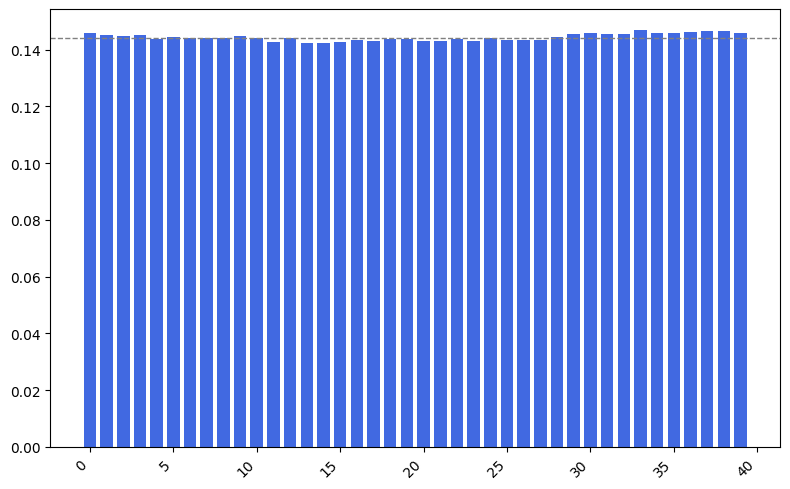

In [319]:
perViewError = perViewError.flatten()
rms_error = np.median(perViewError)
idxs = []
for i, idx in enumerate(images_points):
    idxs.append(i)

plt.figure(figsize=(8,5))
plt.bar(idxs, perViewError, color = 'royalblue', width=.75)

plt.axhline(y=rms_error, color='gray', linestyle='--', linewidth=1, label=f'Média: {rms_error:.2f}')

plt.xticks(rotation=45, ha='right')  # Rotacionar os rótulos das imagens para melhor visualização
plt.tight_layout()  # Ajusta o layout para se encaixar bem na figura
plt.show()

In [320]:
def remove_images(limiar, error, images):
    new_set = []

    for idx, image in enumerate(images):

        if perViewError[idx] > (limiar + error.std()):
            new_set.append(image)

    return new_set

In [321]:
rms_error + 2 * perViewError.std()

0.14664663633039807

In [322]:
images_train, images_test, world_train, world_test = train_test_split(corrected_image_points_vector, corrected_world_points_vector, test_size=0.3) 

ret, cameraMatrix, k, rvecs, tvecs, stdIntrinc, stdExtrinsic, perViewError = cv2.calibrateCameraExtended(world_train, images_train, imgSize, None, None,
                                                                flags=flagsCalib)
print("RMS re-projection error:", ret)
print("Camera Matrix:\n", cameraMatrix)
print("Distortion Parameters:\n", k)

# error = calculate_rms_error(image_set=images_test, pattern_size=(9,7), square_size= 30, camera_matrix=camera_matrix, distortion=distortion)

RMS re-projection error: 0.1434325563641164
Camera Matrix:
 [[485.50917064   0.         267.55199418]
 [  0.         467.15970332 317.23080103]
 [  0.           0.           1.        ]]
Distortion Parameters:
 [[-0.03077335 -0.07329687  0.00047089 -0.00052757 -0.02554972 -0.03035987
  -0.07636014 -0.02378159  0.          0.          0.          0.
   0.          0.        ]]


In [323]:
squareSize = 0.1
calculate_rms_error(patternSize, squareSize, images_test, cameraMatrix, k , per_view_error=True)

RMS Error of Image 0: 0.1508367765086492 px
RMS Error of Image 1: 0.14226370632909086 px
RMS Error of Image 2: 0.14569559174466298 px
RMS Error of Image 3: 0.14318597754463971 px
RMS Error of Image 4: 0.14397295188972306 px
RMS Error of Image 5: 0.15669436700377673 px
RMS Error of Image 6: 0.1428695347639551 px
RMS Error of Image 7: 0.1484708591671478 px
RMS Error of Image 8: 0.14415312974611075 px
RMS Error of Image 9: 0.1453813501763139 px
RMS Error of Image 10: 0.14306137215334694 px
RMS Error of Image 11: 0.1423677707883184 px
Median RMS error:  0.1440630408179169


0.1440630408179169

In [324]:
cross_validation_camera(world_train, images_train)

Median RMS error:  0.1427408285811746
Median RMS error:  0.14299113005641326


Median RMS error:  0.14275500149016085
Median RMS error:  0.14325127513009717


Median RMS error:  0.14312618603856084
Median RMS error:  0.14404748415063054


Median RMS error:  0.14280924515632337
Median RMS error:  0.14281246401857217


Median RMS error:  0.14298415202492895
Median RMS error:  0.14363347316734248


Median RMS error:  0.142991290852575
Median RMS error:  0.14361156000112577


Median RMS error:  0.14321878553704673
Median RMS error:  0.1443481160901337


Median RMS error:  0.14347442262861837
Median RMS error:  0.14402187836932137


Median RMS error:  0.14299209713743427
Median RMS error:  0.14309662563985862


Median RMS error:  0.1429970632606993
Median RMS error:  0.14381154700355858


Var E_train:  5.02281172393089e-08
Var E_test:  2.5953518134648465e-07
Delta^2 E_KF:  0.0005565638315465653


In [325]:
corrected_image_points_vector[0]

array([[[198.70174, 218.9248 ]],

       [[232.01514, 220.09398]],

       [[264.57523, 221.03056]],

       [[296.38965, 222.34079]],

       [[327.99258, 223.4521 ]],

       [[358.90738, 224.65495]],

       [[389.1617 , 225.92606]],

       [[198.23294, 249.92673]],

       [[231.82791, 250.87987]],

       [[264.78833, 251.81575]],

       [[296.9533 , 252.77325]],

       [[328.8544 , 253.45352]],

       [[359.7163 , 254.406  ]],

       [[390.56686, 255.34766]],

       [[197.68286, 281.29572]],

       [[231.6624 , 282.14627]],

       [[264.79996, 282.65533]],

       [[297.35544, 283.20258]],

       [[329.45798, 284.2654 ]],

       [[360.99774, 284.84946]],

       [[391.68246, 285.58926]],

       [[197.44102, 313.49832]],

       [[231.58034, 313.919  ]],

       [[265.02112, 314.31735]],

       [[297.6152 , 314.73874]],

       [[330.05038, 315.12817]],

       [[361.94855, 315.58896]],

       [[393.08524, 315.8419 ]],

       [[196.8289 , 346.55798]],

       [[231.3